# Programming for Data Science and Artificial Intelligence

## Supervised Learning - Classification - Decision Trees

### Readings: 
- [VANDER] Ch5
- [HASTIE] Ch9, 13

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Decision Trees

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification.

#### How is a Decision Tree fit?

* Which variables to include on the tree?
* How to choose the threshold?
* When to stop the tree?

**Key idea is that we want to choose the feature that has the lowest "impurity" to split our tree, thus our tree can reach the decision as fast as possible with smallest height possible**

One way to measure impurity is using **Gini index** (another one is entropy but which measure very similar thing) with the following formula:

$$ I_{G} = 1 - \sum_{i=1}^{c} p_{i}^{2} $$

where $c$ is number of classes, and $p_{i}$ is the probability of each class.  For example, let's say our X is <code>[[2],[3],[10],[19]]</code> and y is <code>[0, 0, 1, 1]</code>.  That is, if a node has 4 samples, and 2 samples are of class cancer, and 2 samples are of no cancer, then the probability of each class is

$$p_{cancer}=(2/4)^2 = 0.25$$ and $$p_{no-cancer}=(2/4)^2 = 0.25$$   

Thus the gini index of this node is

$$ I_{G} = 1 - (0.25 + 0.25) = 0.5 $$

Then we need to decide how to best split this node so we can get the lowest gini (highest purity) children.

For example, if we split this sample with **x1 < 3**: we will get left node X as <code>[[2]]</code> and y as <code>[0]</code> and the right node X as <code>[[3],[10],[19]]</code> and y as <code>[0, 1, 1]</code>.  The weighted gini of the children are 

$$ 1/4*I_{leftG} + 3/4 * I_{rightG} =  $$
$$ 1/4 * (1 - (1/1)^2) + 3/4 * (1 - (1/3)^2 - (2/3)^2) = 0.33 $$

Hmm...but we know we can split better, right?  Let's try **x1 < 4**: we will get left node X as <code>[[2],[3]]</code> and y as <code>[0, 0]</code> and the right node X as <code>[[10],[19]]</code> and y as <code>[1, 1]</code>.  If you do the math right, the gini is 0!

$$ 2/4 * (1 - (2/2)^2) + 2/4 * (1 - (2/2)^2 ) = 0 $$

Thus, in conclusion, we can say that spliting **x1<4** is a much better split than **x1<3**.  In practice, to really find the best split, it is an exhaustive and greedy algorithm, in which we have to iterate and check every value on each feature as a candidate split, find the gini index.  

#### How do we find all threshold for continuous values?

We can sort all features.  Then we are identify critical value using the midpoint between all consecutive values.  For example, given X is <code>[[2],[3],[10],[19]]</code>, the critical value to compare is 2.5, 6.5 and 14.5.

The code can be implemented in several ways.  Example are shown below:

In [11]:
"""
Idea is simple.  Simply loop through all possible threshold:
2.5, 6.5, 14.5.  

2.5 threshold will give 
[0]         [0, 1, 1]
6.5 threshold will give
[0, 0]      [1, 1]
14.5 threshold will give
[0, 0, 1]   [1]

Then we simply calculate the best gini.

This approach work best if we first sort
our sample to be in order, since we will have fast way
to tell what are the feature value used to split that particular 
way.

"""
def find_split(X, y, n_classes):
    """ Find split where children has lowest impurity possible
    in condition where the purity should also be less than the parent,
    if not, stop.
    """
    n_samples, n_features = X.shape
    if n_samples <= 1:
        return None, None
    
    #so it will not have any warning about "referenced before assignments"
    feature_ix, threshold = None, None
    
    # Count of each class in the current node.
    sample_per_class_parent = [np.sum(y == c) for c in range(n_classes)] #[2, 2]
    
    # Gini of parent node.
    best_gini = 1.0 - sum((n / n_samples) ** 2 for n in sample_per_class_parent)

    # Loop through all features.
    for feature in range(n_features):
        
        # Sort data along selected feature.
        sample_sorted = sorted(X[:, feature]) #[2, 3, 10, 19]
        sort_idx = np.argsort(X[:, feature])
        y_sorted = y[sort_idx] #[0, 0, 1, 1]
                
        sample_per_class_left = [0] * n_classes   #[0, 0]
        
        sample_per_class_right = sample_per_class_parent.copy() #[2, 2]
        
        #loop through each threshold, 2.5, 6.5, 14.5
        #1st iter: [-] [-++]
        #2nd iter: [--] [++]
        #3rd iter: [--+] [+]
        for i in range(1, n_samples): #1 to 3 (excluding 4)
            #the class of that sample
            c = y_sorted[i - 1]  #[0]
            
            #put the sample to the left
            sample_per_class_left[c] += 1  #[1, 0]
                        
            #take the sample out from the right  [1, 2]
            sample_per_class_right[c] -= 1
            
            gini_left = 1.0 - sum(
                (sample_per_class_left[x] / i) ** 2 for x in range(n_classes)
            )
                        
            #we divided by n_samples - i since we know that the left amount of samples
            #since left side has already i samples
            gini_right = 1.0 - sum(
                (sample_per_class_right[x] / (n_samples - i)) ** 2 for x in range(n_classes)
            )

            #weighted gini
            weighted_gini = ((i / n_samples) * gini_left) + ( (n_samples - i) /n_samples) * gini_right

            # in case the value are the same, we do not split
            # (both have to end up on the same side of a split).
            if sample_sorted[i] == sample_sorted[i - 1]:
                continue

            if weighted_gini < best_gini:
                best_gini = weighted_gini
                feature_ix = feature
                threshold = (sample_sorted[i] + sample_sorted[i - 1]) / 2  # midpoint

    #return the feature number and threshold 
    #used to find best split
    return feature_ix, threshold

X = np.array([[2],[3],[10],[19]])
y = np.array([0, 0, 1, 1])
feature, threshold = find_split(X, y, len(set(y)))

#will print 0, 6.5
print("Best feature used for split: ", feature)
print("Best threshold used for split: ", threshold)

Best feature used for split:  0
Best threshold used for split:  6.5


### Scratch

One all value are exhausted, we can then use the best decision note as our split node.  Then when we go to the next node, we have to repeat again.  This algorithm is called **CART (Classification and Regression Trees)** algorithm, where the recursion keeps on going until certain stop criteria, such as maximum tree depth is reached, or no split can produce two children with lower purity.

**Implementation steps:**

1. Calculate the purity of the data
2. Select a candidate split
3. Calculate the purity of the data after the split
4. Repeat for all variables
5. Choose the variable with the lowest impurity 
6. Repeat for each split until some stop criteria is met

Example could be stop criteria could be max tree depth, or minimum node records.

Here are some snippets of the possible implementation 
of Decision Tree

In [12]:
#To help with our implementation, we create a class Node
class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

Let's try implement Decision Tree to see how it looks

In [16]:
def fit(Xtrain, ytrain, n_classes, depth=0):  
    n_samples, n_features = Xtrain.shape
    num_samples_per_class = [np.sum(ytrain == i) for i in range(n_classes)]
    #predicted class using the majority of sample class
    predicted_class = np.argmax(num_samples_per_class)
    
    #define the parent node
    node = Node(
        gini = 1 - sum((np.sum(y == c) / n_samples) ** 2 for c in range(n_classes)),
        predicted_class=predicted_class,
        num_samples = ytrain.size,
        num_samples_per_class = num_samples_per_class,
        )
        
    #perform recursion
    feature, threshold = find_split(Xtrain, ytrain, n_classes)
    if feature is not None:
        #take all the indices that is less than threshold
        indices_left = X[:, feature] < threshold
        X_left, y_left = X[indices_left], y[indices_left]

        #tilde for negation
        X_right, y_right = X[~indices_left], y[~indices_left]

        #take note for later decision
        node.feature_index = feature
        node.threshold = threshold
        node.left = fit(X_left, y_left, n_classes, depth + 1)
        node.right = fit(X_right, y_right, n_classes, depth + 1)
    return node

#to predict, it is as simple as moving 
#through the tree 
def predict(sample, tree):
    while tree.left:
        if sample[tree.feature_index] < tree.threshold:
            tree = tree.left
        else:
            tree = tree.right
    return tree.predicted_class

#fit starting with tree depth = 0
Xtrain = np.array([[2, 5],[3, 5],[10, 5],[19, 5]])
ytrain = np.array([0, 0, 1, 1])
Xtest = np.array(([[4, 6],[6, 9],[9, 2],[12, 8]]))
ytest = np.array([0, 0, 1, 1])

tree = fit(Xtrain, ytrain, len(set(ytrain)))
pred = [predict(x, tree) for x in Xtest]

print("Tree feature ind: ", tree.feature_index)
print("Tree threshold: ", tree.threshold)
print("Pred: ", np.array(pred))
print("ytest: ", ytest)

Tree feature ind:  0
Tree threshold:  6.5
Pred:  [0 0 1 1]
ytest:  [0 0 1 1]


In [20]:
print(tree.left)

### Sklearn

(200, 200)


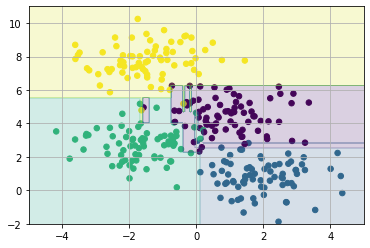

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

model = DecisionTreeClassifier().fit(X, y)

def plot_tree(model, X, y):
    plt.grid()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30)

    xx, yy = np.meshgrid(np.linspace(-5, 5, num=200),
                             np.linspace(-2, 11, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    print(Z.shape)
    
    # Create a color plot with the results
    n_classes = len(set(y))
    contours = plt.contourf(xx, yy, Z, alpha=0.2)


plot_tree(model, X, y)

### ===Task===

Let's modify the above scratch code to
- Modify the scratch code so it can accept an hyperparameter <code>max_depth</code>, in which it will continue create the tree until max_depth is reached.
- Put everything into a class <code>DecisionTree</code>.  It should have at least two methods, <code>fit()</code>, and <code>predict()</code>
- Load the iris data and try with your class

### When to use Decision Trees

Decision Trees are more powerful than other classification in a sense that it can work very well given heterogenous features.  However, the downsides is high possibility of over-fitting: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.

However, by using information from multiple decision trees training on subset of data (i.e., random forests), we might expect better results.  We shall explore random forests and a general family of ensembles later in our course.